# Financial Data Analysis
The data set includes 5000 observations with fourteen variables divided into four different measurement categories. The binary category has five variables, including the target variable personal loan, also securities account, CD account, online banking and credit card. The interval category contains five variables: age, experience, income, CC avg and mortgage. The ordinal category includes the variables family and education. The last category is nominal with ID and Zip code. The variable ID does not add any interesting information e.g. individual association between a person (indicated by ID) and loan does not provide any general conclusion for future potential loan customers. Therefore, it will be neglected in the examination.

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()

In [2]:
loan_df = pd.read_excel(
    "../input/personal-loan-modelling/bank-personal-loan-data.xlsx", "Data"
).set_index("ID")
loan_df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# lets check for the types auto assigned to data
loan_df.dtypes

Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

## Description of Data
We can divide the columns into three categories: binary data, interval data, ordinal data. **Personal Loan** is the target variable for our analysis!

### Binary Data
|Field|Description|
|-|-|
|**Personal Loan**|Did this customer accept the personal loan offered in the last campaign?|
|Securities Account|Does the customer have a securities account with the bank?|
|CD Account|Does the customer have a certificate of deposit (CD) account with the bank?|
|Online|Does the customer use internet banking facilities?|
|CreditCard|Does the customer use a credit card issued by UniversalBank?|

### Interval Data
|Field|Description|
|-|-|
|Age|Customer's age in completed years|
|Experience|Years of professional experience|
|Income|Annual income of the customer|
|CCAvg|Avg. spending on credit cards per month|
|Mortgage|Value of house mortgage|

### Categorical Data
|Field|Description|
|-|-|
|Family|Family size of the customer|
|Education|Educational level of the customer|
|ZIPCode|Home Address ZIP code|

We have to change the data accordingly!

In [4]:
loan_df['ZIP Code'] = loan_df['ZIP Code'].astype('category')
loan_df["CD Account"] = loan_df["CD Account"].astype('category')
loan_df["Personal Loan"] = loan_df["Personal Loan"].astype('category')
loan_df["Online"] = loan_df["Online"].astype('category')
loan_df["CreditCard"] = loan_df["CreditCard"].astype('category')
loan_df["Education"] = loan_df["Education"].astype('category')
loan_df["Family"] = loan_df["Family"].astype('category')
loan_df["Securities Account"] = loan_df["Securities Account"].astype('category')
loan_df.dtypes

Age                      int64
Experience               int64
Income                   int64
ZIP Code              category
Family                category
CCAvg                  float64
Education             category
Mortgage                 int64
Personal Loan         category
Securities Account    category
CD Account            category
Online                category
CreditCard            category
dtype: object

### EDA

In [5]:
# Here we resolve the Education column
loan_df.Education = pd.Series(
    loan_df.Education.replace({1: "Professional", 2: "Undergrad", 3: "Graduate"}),
    dtype="category",
)

In [6]:
pd.concat(
    [
        loan_df.describe().transpose(),
        pd.DataFrame(loan_df.apply(lambda x: len(x.unique())), columns=["nUnique"]),
    ],
    axis=1,
)

,count,mean,std,min,25%,50%,75%,max,nUnique
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0,45
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0,47
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0,162
CCAvg,5000.0,1.937913,1.747666,0.0,0.7,1.5,2.5,10.0,108
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0,347
ZIP Code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467
Family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
Personal Loan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
Securities Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


As we can see in the "count" column there are no missing values. One thing that grabs our attention: The min of Experience is -3. There are some negative values in Experience. Further investigation:

In [7]:
len(loan_df[loan_df["Experience"] < 0])

52

In total there are 52 rows with negative experience values. We will extrapolate those values using the average for same age and education group. Since we can't really interpret negative experience we change that data. It is a reasonable assumption, that Experience grows linear with age, while the growth is dependent on Education. We will use this approach to fill the values. Resulting in three linear models.

## Correction of problematic values

In [8]:
loan_df["Education"].unique().tolist()

['Professional', 'Undergrad', 'Graduate']

In [9]:
X = {
    "Professional": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Professional")
    ][["Age"]],
    "Undergrad": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Undergrad")
    ][["Age"]],
    "Graduate": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Graduate")
    ][["Age"]],
}

y = {
    "Professional": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Professional")
    ]["Experience"],
    "Undergrad": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Undergrad")
    ]["Experience"],
    "Graduate": loan_df[
        (loan_df["Experience"] >= 0) & (loan_df["Education"] == "Graduate")
    ]["Experience"],
}

In [10]:
model = {
    "Professional": LinearRegression().fit(X["Professional"], y["Professional"]),
    "Undergrad": LinearRegression().fit(X["Undergrad"], y["Undergrad"]),
    "Graduate": LinearRegression().fit(X["Graduate"], y["Graduate"]),
}

Now we have three Models. One to predict Experience for Professionals, one to predict Experience for Graduates and one to predict experience for Undergrads. The next step is to apply those models to the data with negative experience values.

In [11]:
predictions = {
    "Professional": np.round(np.maximum(
        0,
        model["Professional"].predict(
            loan_df[
                (loan_df["Experience"] < 0) & (loan_df["Education"] == "Professional")
            ][["Age"]]
        ),
    )),
    "Undergrad": np.round(np.maximum(
        0,
        model["Undergrad"].predict(
            loan_df[
                (loan_df["Experience"] < 0) & (loan_df["Education"] == "Undergrad")
            ][["Age"]]
        ),
    )),
    "Graduate": np.round(np.maximum(
        0,
        model["Graduate"].predict(
            loan_df[(loan_df["Experience"] < 0) & (loan_df["Education"] == "Graduate")][
                ["Age"]
            ]
        ),
    )),
}

In [12]:
for key, preds in predictions.items():
    loan_df.loc[
        (loan_df["Experience"] < 0) & (loan_df["Education"] == key), "Experience"
    ] = preds

Now there should be no entries with negative Experience value left.

In [13]:
len(loan_df[loan_df["Experience"] < 0])

0

Success!

### Visualization of Features
Our data has multiple categorical values. We will first use those to split our dataset into groups and see Loan Acceptance in each group.

In [14]:
# This is the probablity that a person with Education level X accepted a Loan
#sns.catplot(data=loan_df, x="Family", hue="Education", y="Personal Loan", kind="bar", errorbar="se")

As we can see there are almost no Professionals with small Family sizes that accepted a loan. Besides that, loan acceptance is pretty well spread with slightly higher values for Graduates and Undergrads.

This is valuable information for us. When we try to extract variables that are good predictors for "Personal Loan" we can ignore professionals with small familys. We also dont have to spend marketing money on those individuals.

To get a better understanding of the contributing factors we will have a look at two heatmaps. One will focus on factors for loan acceptance of professionals with a family size of 3 or 4. The other one will look for factors focusing on Undergrads and Grads.

<AxesSubplot:>

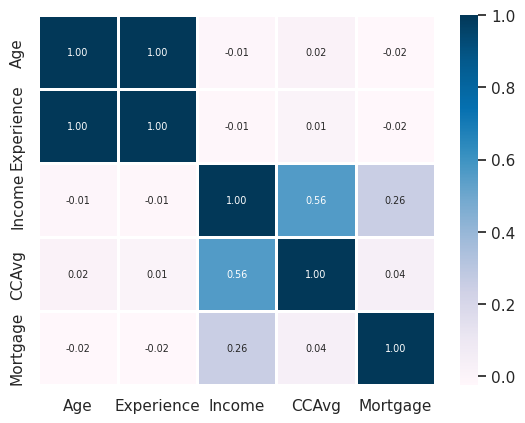

In [15]:
sns.heatmap(
    loan_df[(loan_df["Education"] == "Professional") & ((loan_df["Family"] == 3) | (loan_df["Family"] == 4))].corr(),
    annot=True,
    annot_kws={"size": "xx-small"},
    fmt=".2f",
    cmap="PuBu",
    linewidths=0.75,
)

<AxesSubplot:>

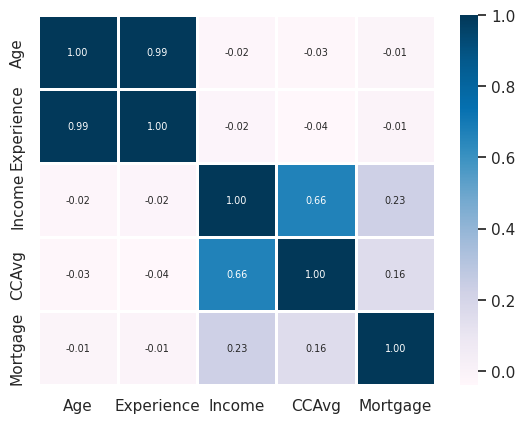

In [16]:
sns.heatmap(
    loan_df[loan_df["Education"] != "Professional"].corr(),
    annot=True,
    annot_kws={"size": "xx-small"},
    fmt=".2f",
    cmap="PuBu",
    linewidths=0.75,
)

As we can see Personal Loan has a strong correlation with "Income" "CCAvg" and "Online".

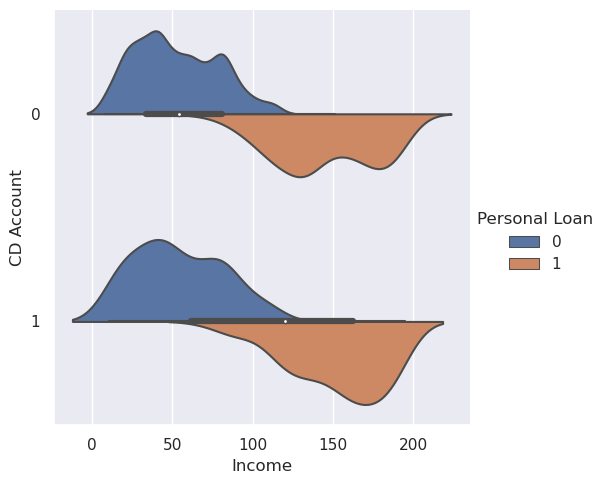

In [17]:
#loan_df["CD Account"] = loan_df["CD Account"].astype('category')
sns.catplot(
    loan_df[loan_df["Education"] != "Professional"],
    x="Income", y="CD Account", hue="Personal Loan", kind="violin", split=True)

The height of the bar tells us the mean of the value. The black bar the std deviation. As we can see std deviation on income data is quite high.

The correlation Matrix already show us that Personal Loan correlates highly with Income. Lets have a closer look:

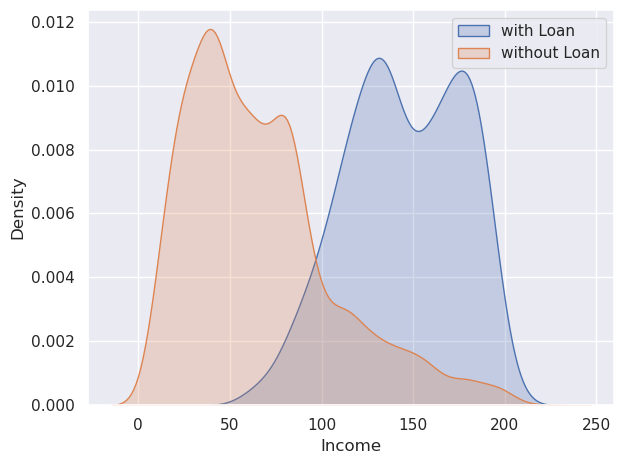

In [18]:
fig, ax = plt.subplots()

sns.kdeplot(
    loan_df[loan_df["Personal Loan"] == 1],
    x="Income",
    label="with Loan",
    fill=True,
    ax=ax,
)

sns.kdeplot(
    loan_df[loan_df["Personal Loan"] == 0],
    x="Income",
    label="without Loan",
    fill=True,
    ax=ax,
)

ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Education', ylabel='Income'>

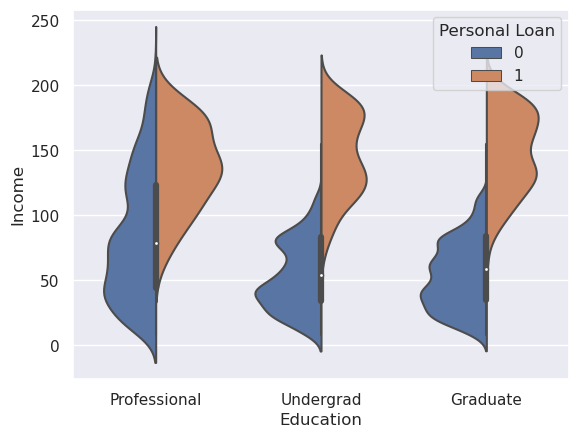

In [19]:
sns.violinplot(data=loan_df, x="Education", y="Income", hue="Personal Loan", split=True)

As we can see here people that accepted the last Loan offer tend to have a much higher Income. 

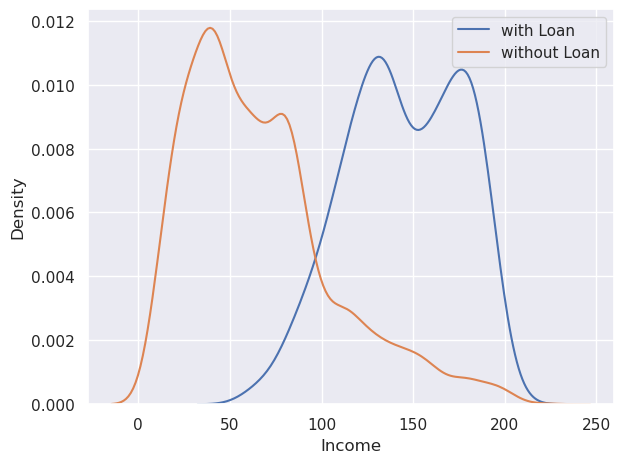

In [20]:
## CCAvg und Online
fig, ax = plt.subplots()

sns.kdeplot(
    loan_df[loan_df["Personal Loan"] == 1],
    x="Income",
    label="with Loan",
    fill=False,
    ax=ax,
)

sns.kdeplot(
    loan_df[loan_df["Personal Loan"] == 0],
    x="Income",
    label="without Loan",
    fill=False,
    ax=ax,
)

ax.legend()
plt.tight_layout()
plt.show()